# Import Libraries

In [483]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import time
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from scipy.stats import kstest
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error


# Import Data

In [489]:
# Import Data
data = pd.read_csv(r"C:\Users\tgmce\Downloads\Advertising Budget and Sales.csv")

# Rename columns
data = data.rename(columns = {'Unnamed: 0': 'Campaign', 'TV Ad Budget ($)': 'TV', 'Radio Ad Budget ($)': 'Radio',
                              'Newspaper Ad Budget ($)': 'Newspaper', 'Sales ($)': 'Sales'})

# Put data into thousands of dollars. Columns are transformed using the square root function to help normalize the data.
data['TV'] = data['TV'].apply(lambda x: np.sqrt(x))
data['Radio'] = data['Radio'].apply(lambda x: np.sqrt(x))
data['Newspaper'] = data['Newspaper'].apply(lambda x: np.sqrt(x))
data['Sales'] = data['Sales'].apply(lambda x: np.sqrt(x))

# Remove Campaign column
data = data.drop('Campaign', axis = 1)

# Read data
data

,TV,Radio,Newspaper,Sales
0,15.169047,6.148170,8.318654,4.701064
1,6.670832,6.268971,6.715653,3.224903
2,4.147288,6.774954,8.324662,3.049590
3,12.308534,6.426508,7.648529,4.301163
4,13.446189,3.286335,7.641989,3.591657
...,...,...,...,...
195,6.180615,1.923538,3.714835,2.756810
196,9.705668,2.213594,2.846050,3.114482
197,13.304135,3.049590,2.529822,3.577709
198,16.840428,6.480741,8.136338,5.049752


# Check for Missing Values

In [441]:
# There are no missing values in the dataset
print(data.isna().sum())

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64


# Check for Correlation between Variables 

In [475]:
data.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.039989,0.041734,0.820471
Radio,0.039989,1.000000,0.293695,0.532389
Newspaper,0.041734,0.293695,1.000000,0.201606
Sales,0.820471,0.532389,0.201606,1.000000


# Scatterplot of Independent Variables

Text(0.5, 1.0, 'Newspaper')

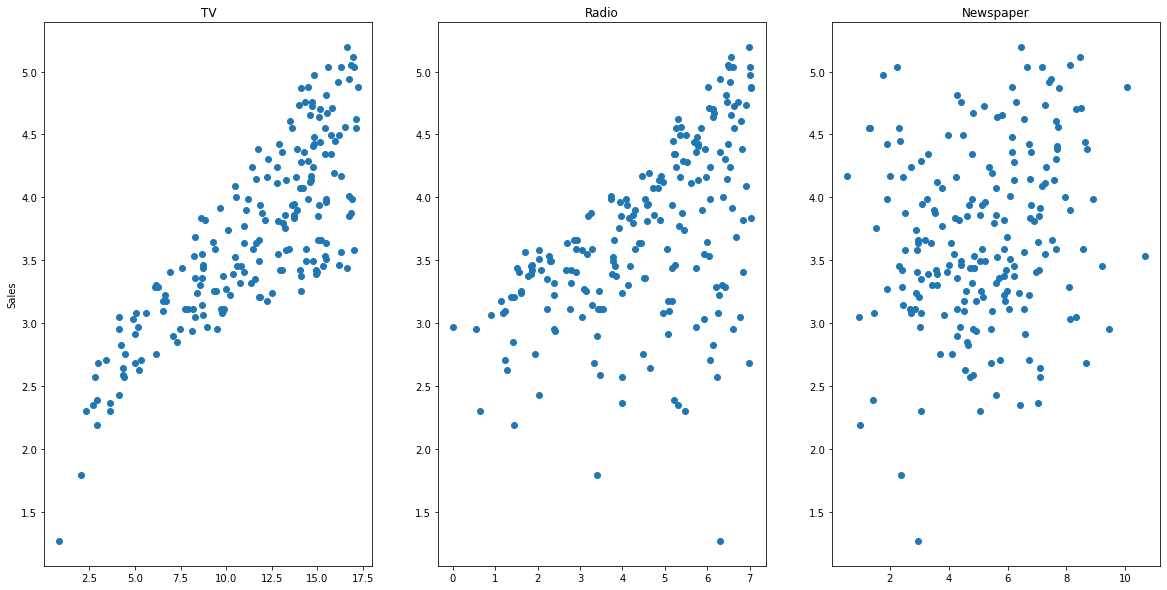

In [442]:
# Three scatter plots of the original data. TV and Radio show a positive, somewhat linear realtionship. Newspaper shows a weak, positive relationship.
figure, axis = plt.subplots(1, 3, figsize = (20,10))

axis[0].scatter(data.TV, data.Sales)
axis[0].set_title("TV")
axis[0].set_ylabel('Sales')

axis[1].scatter(data.Radio, data.Sales)
axis[1].set_title("Radio")

axis[2].scatter(data.Newspaper, data.Sales)
axis[2].set_title("Newspaper")



# Build Initial Model

In [443]:
# Build initial model. Initial R2 is 0.924
ols = sm.OLS(data.iloc[:, -1:], sm.add_constant(data.iloc[:, :-1]))
lm = ols.fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     790.3
Date:                Sun, 30 Apr 2023   Prob (F-statistic):          3.55e-109
Time:                        21:07:28   Log-Likelihood:                 42.500
No. Observations:                 200   AIC:                            -77.00
Df Residuals:                     196   BIC:                            -63.81
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1848      0.059     20.151      0.0

# Scatterplot of Residuals

Text(0, 0.5, 'Residuals')

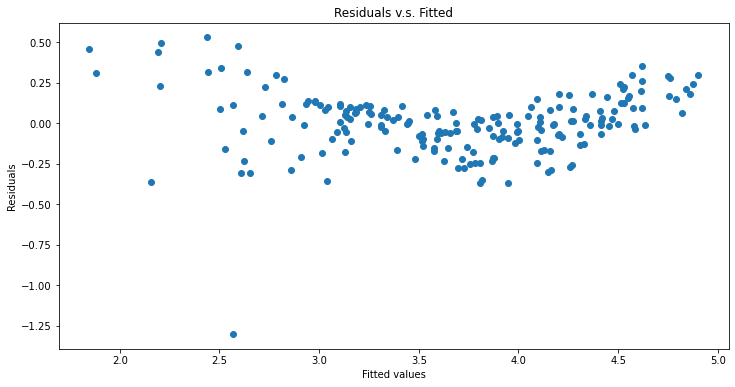

In [444]:
# Scatterplot of residuals to fitted values.There is a slight curve to the scatterplot, indicating a potential violation of the zero mean assumption.
fitted_y = lm.fittedvalues
residual = lm.resid
plt.figure(figsize=(12,6))
plt.scatter(fitted_y,residual)
plt.title('Residuals v.s. Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

# Q-Q Plot

<Figure size 864x432 with 0 Axes>

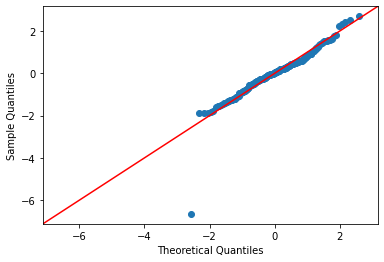

<Figure size 864x432 with 0 Axes>

In [445]:
# One end of the Q-Q plot is off the diagonal line. This means that the normality assumption may be violated.However, it is good enough to continue.
residual_norm = scale(residual)
sm.qqplot(residual_norm, line='45')
plt.figure(figsize=(12,6))

# Histogram Plot

Text(0, 0.5, 'Frequency')

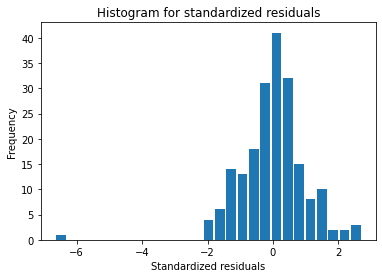

In [431]:
# Normal distribution is skewed left, with several outliers. The histogram is approximately normal.
plt.hist(x=residual_norm, bins='auto', rwidth=0.85)
plt.title('Histogram for standardized residuals')
plt.xlabel('Standardized residuals')
plt.ylabel('Frequency')

# Outlier Detection and Evaluation

Text(0, 0.5, 'Cooks Distance')

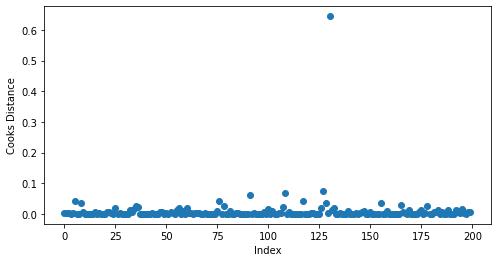

In [433]:
cooks = lm.get_influence().cooks_distance[0]
data[cooks > 1]
plt.figure(figsize = (8, 4))
plt.scatter(data.index, cooks)
plt.xlabel('Index')
plt.ylabel('Cooks Distance')

In [434]:
# Check outlier with large cook's distance value
data[abs(residual_norm) > 3]

,TV,Radio,Newspaper,Sales
130,0.83666,6.292853,2.949576,1.264911


# Best Subset Selection 

In [451]:
# Define the function "fit_lm" with the input as a set of selected features, 
# and output be the fitted model with corresponding RSS, adjust R-square, AIC, and BIC. 
# RSS is calculated following the formula: RSS = \sum (y_hat-y)^2
# Adjusted R-square, AIC, and BIC can be reported from the model directly.

def fit_lm(feature_set):
    ols = sm.OLS(data.Sales, sm.add_constant(data[list(feature_set)]))
    lm = ols.fit()
    RSS = ((lm.predict(sm.add_constant(data[list(feature_set)])) - data.Sales) ** 2).sum()
    rsquared_adj = lm.rsquared_adj
    AIC = lm.aic
    BIC = lm.bic
    return {"model":lm, "RSS":RSS, "Rsquared_adj": rsquared_adj, "AIC":AIC, "BIC": BIC}

# Define the function "getbest" with the input as the number of selected features, 
# and the output as the best model given the pre-specified number of features.
# Here, the best model refers to the one with the lowest RSS as they are all equally complicated (same number of features)

def getbest(k):
    result = []
    for combo in itertools.combinations(data.columns[:-1], k):
        result.append(fit_lm(combo))
    models = pd.DataFrame(result)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model

In [477]:
# We find the best models with the optimal number features, and report the corresponding RSS, adjusted R-square, AIC, BIC.

models_best = pd.DataFrame(columns=["model","RSS","Rsquared_adj","AIC","BIC"])
start = time.time()
for i in range(0,4):
    models_best.loc[i] = getbest(i)
end = time.time()
print(models_best)
print("Best subset selection takes:", end-start, "seconds")
print(models_best.loc[2, "model"].summary())

                                               model         RSS Rsquared_adj  \
0  <statsmodels.regression.linear_model.Regressio...  100.266015         -0.0   
1  <statsmodels.regression.linear_model.Regressio...   32.769649     0.671522   
2  <statsmodels.regression.linear_model.Regressio...    7.705211     0.922372   
3  <statsmodels.regression.linear_model.Regressio...    7.655655     0.922478   

          AIC         BIC  
0  431.477301  434.775618  
1  209.812489  216.409123  
2  -77.708692   -67.81374  
3  -76.999149   -63.80588  
Best subset selection takes: 0.15701699256896973 seconds
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1183.
Date:                Sun, 30 Apr 2023   Prob (F-statistic):          1.72e-110
Ti

Text(0, 0.5, 'bic')

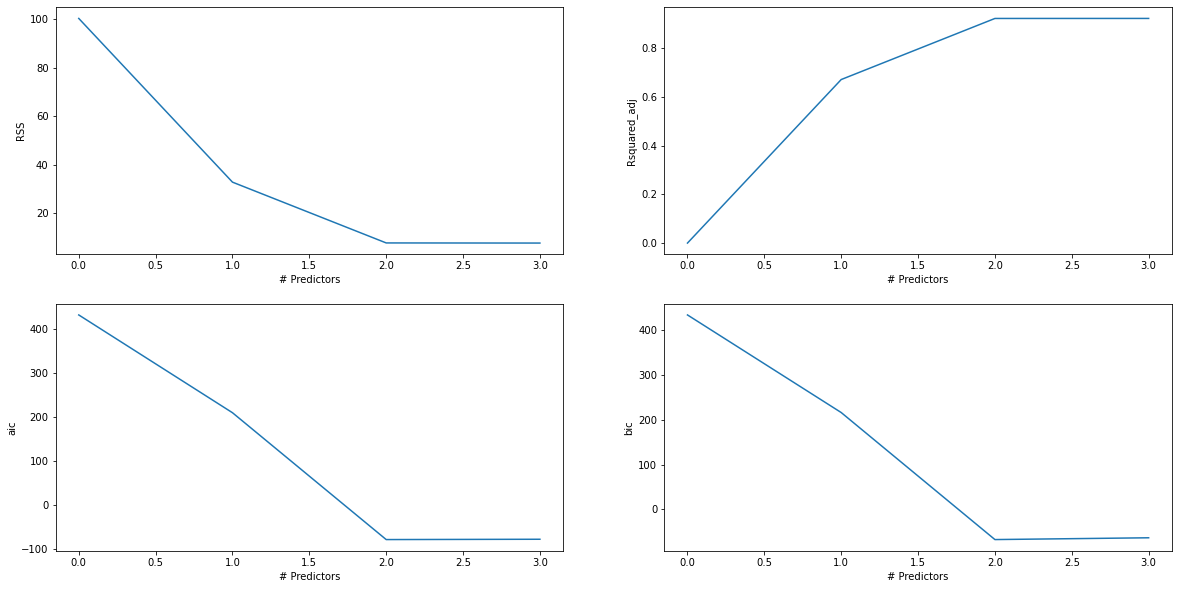

In [490]:
# The optimal number of features for the model is 2, per the charts below.
plt.figure(figsize=(20,10))
plt_rss = plt.subplot(2, 2, 1)
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.subplot(2, 2, 2)
plt.plot(models_best["Rsquared_adj"])
plt.xlabel('# Predictors')
plt.ylabel('Rsquared_adj')
plt.subplot(2, 2, 3)
plt.plot(models_best["AIC"])
plt.xlabel('# Predictors')
plt.ylabel('aic')
plt.subplot(2, 2, 4)
plt.plot(models_best["BIC"])
plt.xlabel('# Predictors')
plt.ylabel('bic')

# K-fold Cross Validation

In [487]:
# Define variables used to obtain testing error.
cv = KFold(n_splits=5, shuffle=True)
x = data.iloc[:, :-1]
y = data.iloc[:, -1:]
error = []

for train_index, test_index in cv.split(data):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    ols = sm.OLS(y_train[["Sales"]], sm.add_constant(x_train[["TV", "Radio"]]))
    lm = ols.fit()
    y_pred = lm.predict(sm.add_constant(x_test[["TV", "Radio"]]))
    error.append(mean_squared_error(y_pred,y_test[["Sales"]]))
     
# 5 total testing errors stored in a list
print('Errors: ', error)
# The average MSE comes out to apprx. 0.0407.
print('Average MSE: ', np.mean(error))

Errors:  [0.03522540960000737, 0.09211818255790809, 0.016406325756942442, 0.03286263953107467, 0.02679652837139803]
Average MSE:  0.040681817163466125
